In [1]:
import os
import platform
import logging

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# import matplotlib.pyplot as plt
import tqdm
import cv2
import pandas as pd

from street_signs_identify.recognizer.ocr_recognizer import EasyOCRRecognizer

In [2]:
from nltk.metrics.distance import edit_distance
from street_signs_identify.data_type.detected_instance import DetectedInstance

class cImageLoader:
    def __init__(self, data_path:str, annotation_file:str="labels.csv"):
        self._data_path = data_path
        self._info = pd.read_csv(os.path.join(self._data_path, annotation_file), encoding='big5', index_col=False)

    def __getitem__(self, idx):
        filename = self._info.loc[idx, "filename"]
        full_name = os.path.join(self._data_path, filename)
        img = cv2.imread(full_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, c = img.shape
        return DetectedInstance([0, 0, w, h], None, None, img)
    
    def __iter__(self):
        for idx in self._info.index:
            yield self[idx]

def compute_normED(pred:str, gt:str):
    if len(gt) == 0 or len(pred) ==0:
        return 0.
    return 1. - edit_distance(pred, gt)/max(len(gt), len(pred))

In [3]:
if platform.system() == "Linux":
    model_ckpt = "./street_signs_identify/recognizer/saved_models/epoch_6701.pth"
    folder_name = "./dataset/"
    data_path = os.path.join(folder_name, "frcnn_craft_cropped_2Penghu")
else:
    
    # demo
    model_path = "./street_signs_identify/detector/saved_models/frcnn.pth"
    folder_name = "./dataset/"
    data_path = os.path.join(folder_name, "frcnn_craft_cropped_2Penghu")

recognizer = EasyOCRRecognizer(model_ckpt)


In [4]:
image_loader = cImageLoader(data_path, annotation_file="labels.csv")
print(image_loader._info)

    filename category              words                       src_file  \
0      0.jpg        3        永順\nYongshu  220720_225837855_Camera_0.jpg   
1      1.jpg        3  永順街\nYingshun St.  220720_225953347_Camera_0.jpg   
2      2.jpg        3  永順街\nYingshun St.  220720_225953347_Camera_0.jpg   
3      3.jpg        3  永順街\nYongshun St.  220720_225953866_Camera_0.jpg   
4      4.jpg        3  永順街\nYongshun St.  220720_225954302_Camera_0.jpg   
..       ...      ...                ...                            ...   
456  456.jpg        3     樹德路\nShude Rd.  220720_234137732_Camera_0.jpg   
457  457.jpg        3     樹德路\nShude Rd.  220720_234137732_Camera_0.jpg   
458  458.jpg        3     樹德路\nShude Rd.  220720_234137732_Camera_0.jpg   
459  459.jpg        4         公務專用\n禁止進入  220720_234353203_Camera_0.jpg   
460  460.jpg        4         公務專用\n禁止進入  220720_234353203_Camera_0.jpg   

     gt_index  CRAFT2GT_IOU frcnn_label  
0           0      0.259490       green  
1           0  

In [5]:
import matplotlib.pyplot as plt

result_df = image_loader._info.copy()
for idx in tqdm.tqdm(result_df.index):
    instance = image_loader[idx]
    instance = recognizer(instance)
    result_df.loc[idx, "recognizer_words"] = instance.info
    result_df.loc[idx, "recognizer_score"] = instance.score
    

100%|██████████| 461/461 [00:15<00:00, 29.45it/s]


In [6]:
result_df["norm_ED"] = result_df.apply(lambda row: compute_normED(row["recognizer_words"], row["words"]), axis=1)
result_df

,filename,category,words,src_file,gt_index,CRAFT2GT_IOU,frcnn_label,recognizer_words,recognizer_score,norm_ED
0,0.jpg,3,永順\nYongshu,220720_225837855_Camera_0.jpg,0,0.259490,green,水駕,0.011860,0.000000
1,1.jpg,3,永順街\nYingshun St.,220720_225953347_Camera_0.jpg,0,0.497149,green,永順南,0.057284,0.125000
2,2.jpg,3,永順街\nYingshun St.,220720_225953347_Camera_0.jpg,0,0.090359,green,,0.000000,0.000000
3,3.jpg,3,永順街\nYongshun St.,220720_225953866_Camera_0.jpg,0,0.432450,green,順衙,0.086000,0.062500
4,4.jpg,3,永順街\nYongshun St.,220720_225954302_Camera_0.jpg,0,0.036907,green,,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
456,456.jpg,3,樹德路\nShude Rd.,220720_234137732_Camera_0.jpg,0,0.337393,green,德,0.996920,0.076923
457,457.jpg,3,樹德路\nShude Rd.,220720_234137732_Camera_0.jpg,0,0.133673,green,路,0.931330,0.076923
458,458.jpg,3,樹德路\nShude Rd.,220720_234137732_Camera_0.jpg,0,0.052905,green,,0.000000,0.000000
459,459.jpg,4,公務專用\n禁止進入,220720_234353203_Camera_0.jpg,0,0.475975,red,站,0.113049,0.000000


In [7]:
y_test = (result_df["norm_ED"]>0) & (result_df["CRAFT2GT_IOU"]>0.3)
y_score = result_df["recognizer_score"]

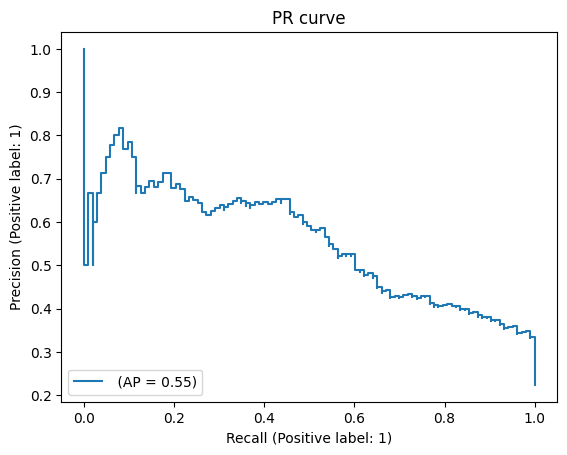

In [8]:
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score

display = PrecisionRecallDisplay.from_predictions(y_test, y_score, name="")
_ = display.ax_.set_title("PR curve")

In [9]:
average_precision_score(y_test, y_score)

0.5521622613727112